## Traducción de Inglés a Sindarin

Funciones listas para traducir una frase o una traducción en bloque:

In [ ]:
import torch

from huggingface_hub import login

token = ""
print("Hugging Face logging")
login(token)

def translate(text, model, tokenizer, do_sample=False, temperature=1.0):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    translated_tokens = model.generate(**inputs, do_sample=do_sample, temperature=temperature)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

def translate_batch(texts, model, tokenizer, batch_size=32, do_sample=False, temperature=1.0):
    translations = []
    model.eval()  # Asegurarse de estar en modo inferencia
    device = "cuda" if torch.cuda.is_available() else "cpu"  # Usar GPU si está disponible
    model.to(device)

    with torch.no_grad():  # Deshabilitar gradientes para inferencia
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, max_length=90, padding=True).to(device)
            translated_tokens = model.generate(**inputs, do_sample=do_sample, temperature=temperature)
            translations.extend(tokenizer.batch_decode(translated_tokens, skip_special_tokens=True))

    return translations

Preparar un conjunto de entrenamiento y otro de evaluación para la tarea de traducir de Inglés a Sindarin, para maximizar las posibilidades de obtener buenos resultados vamos a realizar un entrenamiento y evaluación con overfit. Para ello, prepare un

In [ ]:
from libs.lotr_ds_builder import build_datasets
from datasets import Dataset

# TODO: Utilizar la función build_datasets() y generar un traing_dataset y test_dataset de Inglés a Sindarin
train, test = build_datasets()
train_dataset = train['Sindarin']
test_dataset = test['Sindarin']

# TODO: Cargar los datasets usando la clase Dataset
train_dataset = Dataset.from_dict(train_dataset)
eval_dataset = Dataset.from_dict(test_dataset)

# DONE: Mostrar la primera frase, la utilizaremos para probar los modelos
print(">", train_dataset['translation'][0])

## Entrenar un modelo MarianMT

In [4]:
from transformers import MarianMTModel, MarianTokenizer, MarianConfig

# Crear configuración para un modelo Marian en blanco
config = MarianConfig(
    vocab_size=32000,  # Tamaño del vocabulario (ajústalo según tu caso)
    max_position_embeddings=512,
    encoder_layers=6,
    decoder_layers=6,
    encoder_attention_heads=8,
    decoder_attention_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.1,
    pad_token_id=0,
    eos_token_id=1,
    bos_token_id=2,
)

# Crear el modelo MarianMT desde cero
marian_model_trained = MarianMTModel(config)

# Crear un tokenizador vacío (puedes cargar o definir tu propio vocabulario)
marian_tokenizer_trained = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
marian_model_trained.resize_token_embeddings(len(marian_tokenizer_trained))


marian_model_trained.save_pretrained("./models/trained-marian-en-sindarin")
# Ajustar el tamaño del vocabulario del modelo Marian para que coincida con el tokenizador
marian_tokenizer_trained.save_pretrained("./models/trained-marian-en-sindarin")

def load_trained_marian():
    marian_model = MarianMTModel.from_pretrained("./models/trained-marian-en-sindarin")
    marian_tokenizer = MarianTokenizer.from_pretrained("./models/trained-marian-en-sindarin")
    return marian_model, marian_tokenizer



The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [5]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./models/training/trained-marian-en-sindarin",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    logging_dir='./logs',
    report_to="none"
)

marian_model_trained, marian_tokenizer_trained = load_trained_marian()

def preprocess_function(examples):
    global marian_tokenizer_trained
    inputs_lang = [example['en'] for example in examples['translation']]
    targets_lang =  [example['fo'] for example in examples['translation']]

    model_inputs = marian_tokenizer_trained(inputs_lang, text_target=targets_lang, max_length=128, truncation=True, padding="max_length")
    return model_inputs

encoded_training_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

collator = DataCollatorForSeq2Seq(tokenizer=marian_tokenizer_trained, model=marian_model_trained)
trainer = Trainer(
    model=marian_model_trained,
    args=training_args,
    train_dataset=encoded_training_dataset,
    eval_dataset=encoded_eval_dataset,
    data_collator= collator
)

trainer.train()

marian_model_trained.save_pretrained("./models/trained-marian-en-sindarin")
marian_tokenizer_trained.save_pretrained("./models/trained-marian-en-sindarin")

marian_trained_model, marian_trained_tokenizer = load_trained_marian()
text = "Who brings to us this token of darkness?"
translated_text = translate(text, marian_trained_model, marian_trained_tokenizer)
print(">Marian trained: ", translated_text)

Map: 100%|██████████| 65/65 [00:00<00:00, 6618.51 examples/s]


Epoch,Training Loss,Validation Loss
0,No log,10.531179
1,No log,10.038422
2,No log,9.661125
4,No log,9.324840


/Users/andreacimmino/PycharmProjects/PythonProject/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


>Marian trained:  ãùãÞnnnnnnnnnnnnnnnnnn


## Entrenar un modelo T5
Utilizar un modelo T5 en blanco y entrenarlo enteramente con el dataset inglés-sindarin.

In [6]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config

# Crear configuración para un modelo T5 en blanco
config = T5Config(
    vocab_size=32000,
    d_model=512,
    d_ff=2048,
    num_layers=6,
    num_heads=8,
    dropout_rate=0.1,
    pad_token_id=0,  # Token de padding
    eos_token_id=1,  # Token de fin de secuencia
    decoder_start_token_id=0,  # Token de inicio del decodificador
)

t5_model_trained = T5ForConditionalGeneration(config)

t5_tokenizer_trained = T5Tokenizer.from_pretrained("vgaraujov/t5-base-translation-en-es")

t5_model_trained.save_pretrained("./models/trained-t5-en-sindarin")
t5_tokenizer_trained.save_pretrained("./models/trained-t5-en-sindarin")

def load_t5():
    t5_model = T5ForConditionalGeneration.from_pretrained("./models/trained-t5-en-sindarin")
    t5_tokenizer = T5Tokenizer.from_pretrained("./models/trained-t5-en-sindarin")
    return t5_model, t5_tokenizer


Utilizando el primer modelo, generar una version refinada que esté entrenada con el dataset

In [7]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./models/training/trained-t5-en-sindarin",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    logging_dir='./logs',
    report_to="none"
)


# TODO: Cargar y entrear el modelo `./models/trained-t5-en-sindarin`
t5_model_trained, t5_tokenizer_trained = load_t5()

def preprocess_function(examples):
    global t5_tokenizer_trained
    inputs_lang = [example['en'] for example in examples['translation']]
    targets_lang =  [example['fo'] for example in examples['translation']]

    model_inputs = t5_tokenizer_trained(inputs_lang, text_target=targets_lang, max_length=128, truncation=True, padding="max_length")
    return model_inputs

encoded_training_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

collator = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer_trained, model=t5_model_trained)
trainer = Trainer(
    model=t5_model_trained,
    args=training_args,
    train_dataset=encoded_training_dataset,
    eval_dataset=encoded_eval_dataset,
    data_collator= collator
)

trainer.train()

t5_model_trained.save_pretrained("./models/trained-t5-en-es")
t5_tokenizer_trained.save_pretrained("./models/trained-t5-en-es")


t5_trained_model, t5_trained_tokenizer = load_t5()
text = "Who brings to us this token of darkness?"
translated_text = translate(text, t5_trained_model, t5_trained_tokenizer)
print(">Marian trained: ", translated_text)

Map: 100%|██████████| 65/65 [00:00<00:00, 6097.60 examples/s]
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
0,No log,0.989416
1,No log,0.776430
2,No log,0.702716
4,No log,0.646415


/Users/andreacimmino/PycharmProjects/PythonProject/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


>Marian trained:  


## Comparar todos los modelos usando las metricas BLEU, METEOR y ROUGE

In [8]:
import evaluate


expected_results = [ [row['fo']] for row in eval_dataset['translation']]
inputs = [row['en'] for row in eval_dataset['translation']]

# TODO: calcular las metricas y guardarlas respectivamente en bleu_t5_trained, meteor_t5_trained, rouge_t5_trained y las equivalentes para marian
t5_trained_results = translate_batch(inputs, t5_trained_model, t5_trained_tokenizer, do_sample=True, temperature=1.2)
marianmt_trained_results = translate_batch(inputs, marian_trained_model, marian_trained_tokenizer)

print("Expected Results:", expected_results)
print("T5 Translations:", t5_trained_results)
print("Marian Translations:", marianmt_trained_results)

bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")

bleu_t5_trained = bleu_metric.compute(predictions=t5_trained_results, references=expected_results)
meteor_t5_trained = meteor_metric.compute(predictions=t5_trained_results, references=expected_results)
rouge_t5_trained = rouge_metric.compute(predictions=t5_trained_results, references=expected_results)

bleu_marian_trained = bleu_metric.compute(predictions=marianmt_trained_results, references=expected_results)
meteor_marian_trained = meteor_metric.compute(predictions=marianmt_trained_results, references=expected_results)
rouge_marian_trained = rouge_metric.compute(predictions=marianmt_trained_results, references=expected_results)


Expected Results: [['Hiro hyn hîdh ab ’wanath.'], ['Aragorn, nad no ennas!'], ['Man cenich?'], ['Man le trasta, Brego?'], ['Man cenich?'], ['Ú i vethed'], ['nâ i onnad.'], ['Minlû pedich nin'], ['i aur hen telitha.'], ['Ú i vethednâ i onnad.'], ['Boe bedich go Frodo.'], ['Dolen i vâd o nin.'], ['Si peliannen i vâd na dail lîn.'], ['Si boe ú-dhannathach.'], ['Ae ú-esteliach nad'], ['estelio han'], ['estelio ammen.'], ['Estelio han.'], ['Estelio han.'], ['Estelio veleth.'], ['Nach gwannatha sin?'], ['Ma nathach hi gwannathach or minuial archened?'], ['Ú-ethelithon.'], ['Estelio guru lîn ne dagor.'], ['Ethelithach.'], ['Ú-bedin o gurth ne dagor.'], ['O man pedich?'], ['Edra le men, men na guil edwen'], ['haer o auth a nîr a naeth.'], ['Tollen, i lû.'], ['I chair gwannar na Valannor. Si bado, no círar.'], ['Ah im, ú-’erin veleth lîn?'], ['Gerich veleth nîn, ada.'], ['I amar prestar aen.'], ['Han mathon ne nen.'], ['Han mathon ne chae.'], ['A han noston ned ’wilith.'], ['Mae carnen, Brego, 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


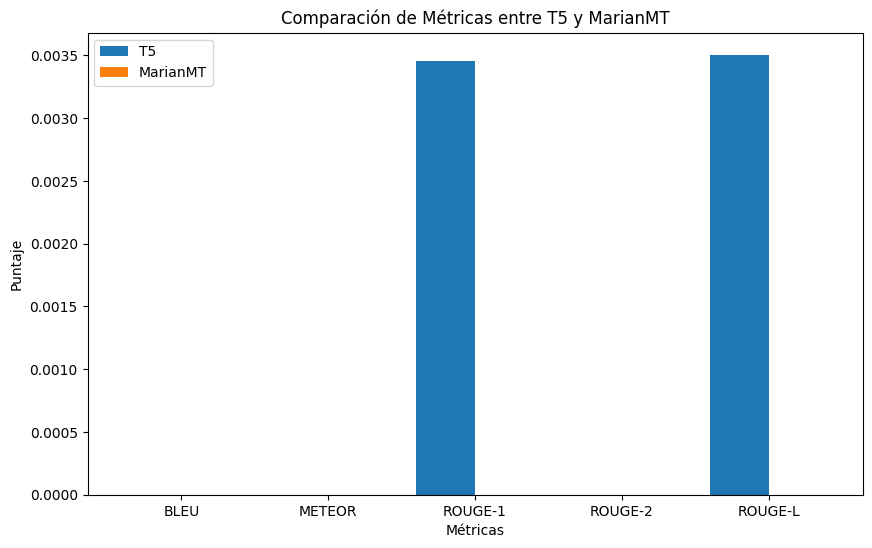

In [9]:
import matplotlib.pyplot as plt

# Sustituye estos valores por los resultados reales
scores_t5 = {
    "BLEU": bleu_t5_trained['bleu'],
    "METEOR": meteor_t5_trained["meteor"],
    "ROUGE-1": rouge_t5_trained["rouge1"],
    "ROUGE-2": rouge_t5_trained["rouge2"],
    "ROUGE-L": rouge_t5_trained["rougeL"]
}

scores_marian = {
    "BLEU": bleu_marian_trained["bleu"],
    "METEOR": meteor_marian_trained["meteor"],
    "ROUGE-1": rouge_marian_trained["rouge1"],
    "ROUGE-2": rouge_marian_trained["rouge2"],
    "ROUGE-L": rouge_marian_trained["rougeL"],
}

# Crear gráfico
labels = list(scores_t5.keys())
t5_values = list(scores_t5.values())
marian_values = list(scores_marian.values())

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, t5_values, width=0.4, label="T5", align="center")
plt.bar([i + 0.4 for i in x], marian_values, width=0.4, label="MarianMT", align="center")

# Configurar etiquetas y leyenda
plt.xticks([i + 0.2 for i in x], labels)
plt.xlabel("Métricas")
plt.ylabel("Puntaje")
plt.title("Comparación de Métricas entre T5 y MarianMT")
plt.legend()